In [22]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [122]:
from typing import Tuple, List

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.testing import assert_frame_equal

sns.set()

<IPython.core.display.Javascript object>

### Read data

In [125]:
df_accounts = pd.read_csv("../data/accounts.csv", parse_dates=["update_date"])
df_transactions = pd.read_csv("../data/transactions.csv", parse_dates=["date"]).drop(
    ["Unnamed: 0"], axis=1
)

<IPython.core.display.Javascript object>

In [150]:
df_transactions.isna().sum()

account_id    0
amount        0
date          0
dtype: int64

<IPython.core.display.Javascript object>

### Filter data by number of hitory days

In [126]:
def keep_accounts_by_history(
    df: pd.DataFrame, min_days: int
) -> Tuple[pd.DataFrame, List[int]]:
    """
    Returns number of history days per account while keepong only those having more than `min_days`,
    and returns a list of these acounts ids.
    """
    df_transactions_by_account = (
        df.groupby("account_id")["date"].agg(["size", "min", "max"]).reset_index()
    )
    df_transactions_by_account["count_days_of_history"] = (
        df_transactions_by_account["max"] - df_transactions_by_account["min"]
    ).dt.days

    df_enough_history = df_transactions_by_account[
        df_transactions_by_account["count_days_of_history"] > min_days
    ]

    df_transactions_by_account[
        "avg_count_transactions_month"
    ] = df_transactions_by_account["size"] / (
        df_transactions_by_account["count_days_of_history"] / 30.0
    )

    return df_enough_history, list(df_enough_history["account_id"].unique())

<IPython.core.display.Javascript object>

In [127]:
# Keep only accounts for which we have more than 180 days of data
MIN_DAYS = 180
df_transactions_by_account, acounts_to_keep_list = keep_accounts_by_history(
    df=df_transactions, min_days=MIN_DAYS
)
print(f"Number of accounts kept: {len(acounts_to_keep_list)}\n{acounts_to_keep_list}")

Number of accounts kept: 33
[2, 3, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 28, 29, 30, 31, 33, 34, 37, 38, 40, 41, 42, 43, 45, 46, 47, 49]


<IPython.core.display.Javascript object>

In [148]:
df_transactions_by_account.head()

,account_id,size,min,max,count_days_of_history
0,2,1032,2017-05-26,2020-01-16,965
1,3,518,2019-06-20,2020-01-21,215
2,5,216,2018-12-19,2019-12-23,369
3,7,344,2018-12-05,2020-01-22,413
4,8,1744,2018-10-15,2020-01-23,465


<IPython.core.display.Javascript object>

In [128]:
# Update input data
df_transactions = df_transactions[
    df_transactions["account_id"].isin(acounts_to_keep_list)
]
df_accounts = df_accounts[df_accounts["id"].isin(acounts_to_keep_list)]

# Save new data sets
df_transactions.to_csv("../data/transactions_enough_history.csv", index=False)
df_accounts.to_csv("../data/accounts_enough_history.csv", index=False)

<IPython.core.display.Javascript object>

### Did all transactions happen before the balance update date ?

In [129]:
df_transactions_and_balance_by_account = pd.merge(
    df_transactions_by_account,
    df_accounts,
    how="left",
    left_on="account_id",
    right_on="id",
    sort=False,
)
print(f"Do we have transactions that happened after the balance update ? \
{((df_transactions_by_account['max'] - df_transactions_by_account['min']).dt.days < 0).any()}")


Do we have transactions that happened after the balance update ? False


<IPython.core.display.Javascript object>

In [151]:
df_transactions_and_balance_by_account

,account_id,size,min,max,count_days_of_history,id,balance,update_date
0,2,1032,2017-05-26,2020-01-16,965,2,3.52,2020-01-16
1,3,518,2019-06-20,2020-01-21,215,3,-125.57,2020-01-23
2,5,216,2018-12-19,2019-12-23,369,5,90893.52,2019-12-23
3,7,344,2018-12-05,2020-01-22,413,7,2.53,2020-01-24
4,8,1744,2018-10-15,2020-01-23,465,8,2989.05,2020-01-24
5,9,1008,2019-02-12,2020-01-21,343,9,0.69,2020-01-24
6,12,485,2018-12-24,2020-01-06,378,12,-321.75,2019-12-24
7,13,536,2018-02-05,2019-12-12,675,13,-688.47,2019-12-18
8,14,26,2019-03-14,2019-12-09,270,14,29.58,2019-12-18
9,15,1244,2018-02-19,2020-01-24,704,15,719.27,2020-01-24


<IPython.core.display.Javascript object>

- We can use all transactions to compute accounts balance up to their last transactions.

### Similar accounts

When looking at the DataFrame used previously, if seems like there are two very similar accounts: 16 and 45.

In [130]:
df_transactions_and_balance_by_account.sort_values(by="balance")

,account_id,size,min,max,count_days_of_history,id,balance,update_date
7,13,536,2018-02-05,2019-12-12,675,13,-688.47,2019-12-18
6,12,485,2018-12-24,2020-01-06,378,12,-321.75,2019-12-24
1,3,518,2019-06-20,2020-01-21,215,3,-125.57,2020-01-23
5,9,1008,2019-02-12,2020-01-21,343,9,0.69,2020-01-24
14,22,551,2018-12-03,2020-01-20,413,22,0.91,2020-01-24
3,7,344,2018-12-05,2020-01-22,413,7,2.53,2020-01-24
26,41,391,2018-03-08,2020-01-23,686,41,2.88,2020-01-24
0,2,1032,2017-05-26,2020-01-16,965,2,3.52,2020-01-16
28,43,141,2019-01-03,2019-12-30,361,43,28.26,2019-12-31
8,14,26,2019-03-14,2019-12-09,270,14,29.58,2019-12-18


<IPython.core.display.Javascript object>

Let us plot their transactions by date

Text(0.5, 1.0, 'Transactions made by both accounts 16 and 45')

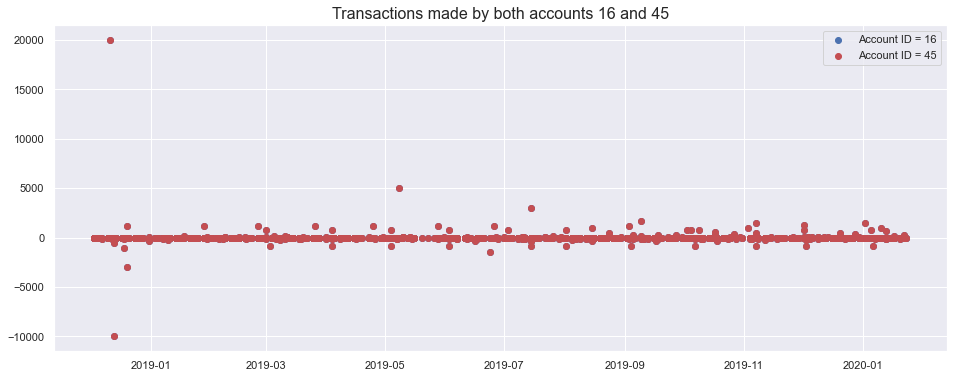

<IPython.core.display.Javascript object>

In [131]:
plt.figure(figsize=(16, 6))
plt.scatter(
    df_transactions[df_transactions["account_id"] == 16]["date"],
    df_transactions[df_transactions["account_id"] == 16]["amount"],
    label="Account ID = 16",
    color="b",
)
plt.scatter(
    df_transactions[df_transactions["account_id"] == 45]["date"],
    df_transactions[df_transactions["account_id"] == 45]["amount"],
    label="Account ID = 45",
    color="r",
)
plt.legend()
plt.title("Transactions made by both accounts 16 and 45", fontsize=16)

Let us make a check of similarity between both accounts.

In [132]:
assert_frame_equal(
        df_transactions[df_transactions["account_id"] == 16]
        .drop(["account_id"], axis=1)
        .sort_values(by=["date", "amount"])
        .reset_index(drop=True),
        df_transactions[df_transactions["account_id"] == 45]
        .drop(["account_id"], axis=1)
        .sort_values(by=["date", "amount"])
        .reset_index(drop=True),
    )


<IPython.core.display.Javascript object>

The two accounts have exactly the same transactions. 

It might me a shared account with two different IDs, or it is just a duplicate. 

Having the time of transactions can be helpful to better understand the reason of that duplicate.

- I will get rid of one of the accounts: 45

In [133]:
acounts_to_keep_list.remove(45)


<IPython.core.display.Javascript object>

I could check make a function that checks all pairs of accounts we have and see if we have other duplicates, but from the previous dataframe, it seems that we don't

In [134]:
# Update input data
df_transactions = df_transactions[
    df_transactions["account_id"].isin(acounts_to_keep_list)
]
df_accounts = df_accounts[df_accounts["id"].isin(acounts_to_keep_list)]

# Save new data sets
df_transactions.to_csv("../data/transactions_enough_history.csv", index=False)
df_accounts.to_csv("../data/accounts_enough_history.csv", index=False)


<IPython.core.display.Javascript object>

### Number of transactions per account

In [135]:
df_transactions_and_balance_by_account[
    ["account_id", "count_days_of_history", "size", "balance"]
].sort_values(by="size")

,account_id,count_days_of_history,size,balance
8,14,270,26,29.58
32,49,228,35,538.84
12,19,406,49,1047.10
15,24,232,68,368.56
13,20,414,103,157.99
25,40,229,132,2199.23
28,43,361,141,28.26
31,47,545,171,2187.22
2,5,369,216,90893.52
18,29,268,250,1410.25


<IPython.core.display.Javascript object>

There is a balance value that is way too high compared to the other values (90893.52 for account_ID=5). Moreover, in Mansa homepage, we see that the maximum amount to lend is 10000. Which is 9 times lower than the previous value. We can consider it as an outlier..

However, I won't remove it, since there is only 32 accounts left, and maybe more similar accounts are to come in the future.


/Users/drissdebbaghnour/.pyenv/versions/3.8.2/envs/mansa_test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of number of days between oldest and newest transaction per account')

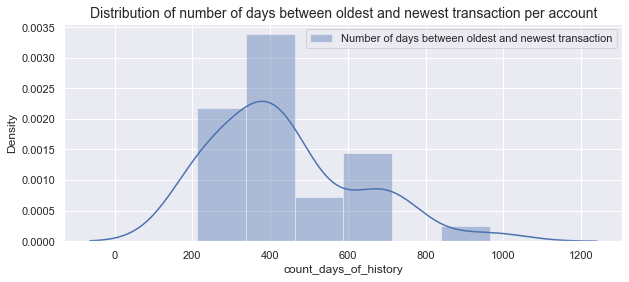

<IPython.core.display.Javascript object>

In [136]:
plt.figure(figsize=(10, 4))
sns.distplot(
    df_transactions_by_account["count_days_of_history"],
    label="Number of days between oldest and newest transaction",
)
plt.legend()
plt.title(
    "Distribution of number of days between oldest and newest transaction per account",
    fontsize=14,
)

/Users/drissdebbaghnour/.pyenv/versions/3.8.2/envs/mansa_test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of number of transactions per account')

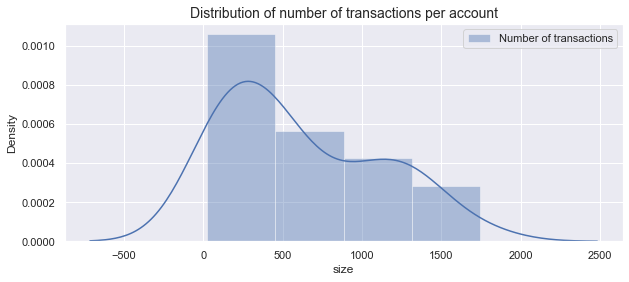

<IPython.core.display.Javascript object>

In [137]:
plt.figure(figsize=(10, 4))
sns.distplot(
    df_transactions_by_account["size"],
    label="Number of transactions",
)
plt.legend()
plt.title("Distribution of number of transactions per account", fontsize=14)

In [138]:
df_transactions_by_account["avg_count_transactions_month"] = df_transactions_by_account[
    "size"
] / (df_transactions_by_account["count_days_of_history"] / 30.0)

<IPython.core.display.Javascript object>

/Users/drissdebbaghnour/.pyenv/versions/3.8.2/envs/mansa_test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


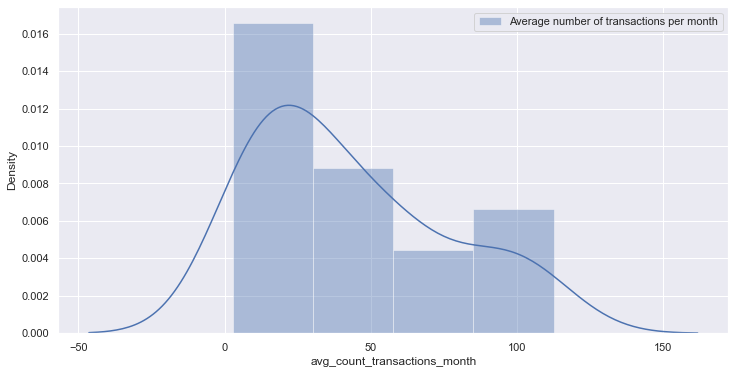

<IPython.core.display.Javascript object>

In [139]:
plt.figure(figsize=(12, 6))
sns.distplot(
    df_transactions_by_account["avg_count_transactions_month"],
    label="Average number of transactions per month",
)
plt.legend()

/Users/drissdebbaghnour/.pyenv/versions/3.8.2/envs/mansa_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x576 with 0 Axes>

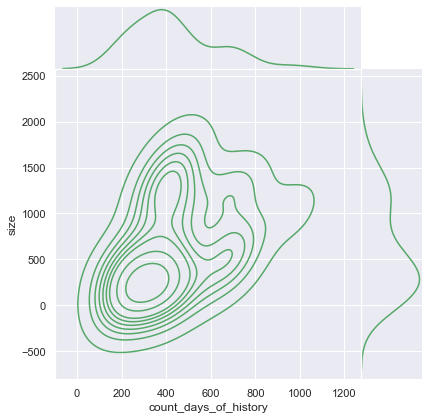

<IPython.core.display.Javascript object>

In [140]:
plt.figure(figsize=(12, 8))
sns.jointplot(
    "count_days_of_history",
    "size",
    data=df_transactions_by_account,
    kind="kde",
    space=0,
    color="g",
)

We observe two modes. It might represent two different categories, active and less active users. 

The accounts might be seperated into two clusters. But for lack of data and time, I will keep them all together. 

### 0 value transactions

We have 80 transactions that are neither expenses nor incomes. Since I am aiming to choose between problem A and problem B, I will remove them.

In [141]:
# Update input data
df_transactions = df_transactions[df_transactions["amount"] != 0]

# Keep only accounts for which we have more than 180 days of data
MIN_DAYS = 180
df_transactions_by_account, acounts_to_keep_list = keep_accounts_by_history(
    df=df_transactions, min_days=MIN_DAYS
)
print(f"Number of accounts kept: {len(acounts_to_keep_list)}\n{acounts_to_keep_list}")

Number of accounts kept: 32
[2, 3, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 28, 29, 30, 31, 33, 34, 37, 38, 40, 41, 42, 43, 46, 47, 49]


<IPython.core.display.Javascript object>

It didn't change the number of accounts kept.

In [145]:
# Save new data sets
df_transactions.to_csv("../data/transactions_enough_history.csv", index=False)
df_accounts.to_csv("../data/accounts_enough_history.csv", index=False)

<IPython.core.display.Javascript object>